In [1]:
!pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\zisha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv('wptw.csv')

C:\Users\zisha\AppData\Local\Temp\ipykernel_40804\1643196432.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wptw.csv')


In [3]:
df.head()

,STORE,UPC,WEEK,MOVE,PRICE,QTY,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
0,2,1122542322,336,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000
1,2,1122542322,337,4,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
2,2,1122542322,338,22,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
3,2,1122542322,339,36,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
4,2,1122542322,344,29,1.79,1,NaN,22.78,1,3FFCA3D70A3D70A4,4036C7AE147AE148


In [4]:
df.tail()

,STORE,UPC,WEEK,MOVE,PRICE,QTY,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
1847012,139,7572536605,395,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847013,139,7572536605,396,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847014,139,7572536605,397,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847015,139,7572536605,398,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847016,139,7572536605,399,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000


In [5]:
df.shape

(1847017, 11)

In [6]:
selected_df = df[(df['UPC'] == 3700063527) & (df['STORE'] == 112)][['WEEK', 'MOVE']]

In [7]:
selected_df.head()

,WEEK,MOVE
420551,1,85
420552,2,89
420553,3,98
420554,4,75
420555,5,114


In [8]:
selected_df.tail()

,WEEK,MOVE
420935,395,70
420936,396,50
420937,397,44
420938,398,59
420939,399,56


In [9]:
print(selected_df.shape)

(389, 2)


In [10]:
# Remove any noise
selected_df['MOVE'] = selected_df['MOVE'][(selected_df['MOVE'] - selected_df['MOVE'].mean()).abs() < 3 * selected_df['MOVE'].std()]
selected_df = selected_df.dropna()

In [11]:
print(selected_df.shape)

(387, 2)


In [12]:
# Add missing weeks
max_week = selected_df['WEEK'].max()
all_weeks = range(1, max_week + 1)
missing_weeks = set(all_weeks) - set(selected_df['WEEK'])
missing_data = [{'WEEK': week, 'MOVE': selected_df['MOVE'].mean()} for week in missing_weeks]
missing_df = pd.DataFrame(missing_data)
selected_df = pd.concat([selected_df, missing_df]).sort_values('WEEK').reset_index(drop=True)
selected_df['MOVE'] = selected_df['MOVE'].fillna(selected_df['MOVE'].mean())

In [13]:
print(selected_df.shape)

(399, 2)


In [14]:
selected_df.head()

,WEEK,MOVE
0,1,85.0
1,2,89.0
2,3,98.0
3,4,75.0
4,5,114.0


In [15]:
selected_df.describe()

,WEEK,MOVE
count,399.000000,399.000000
mean,200.000000,60.152455
std,115.325626,20.802373
min,1.000000,0.000000
25%,100.500000,46.000000
50%,200.000000,57.000000
75%,299.500000,73.000000
max,399.000000,131.000000


In [16]:
selected_df.set_index('WEEK', inplace=True)

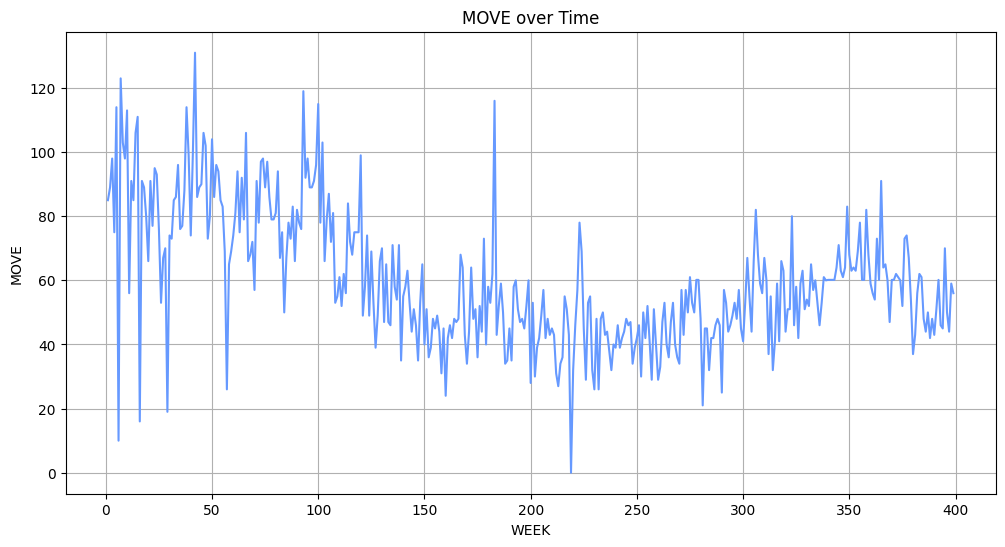

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(selected_df, color = '#6699ff')
plt.title('MOVE over Time')
plt.xlabel('WEEK')
plt.ylabel('MOVE')
plt.grid(True)
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(dataframe):
    test_result = adfuller(dataframe)
    print("ADF Statistic:", test_result[0])
    print("p-value:", test_result[1])
    print("Lags Used:", test_result[2])
    print("Number of Observations Used:", test_result[3])
    print("Critical Values:")
    for key, value in test_result[4].items():
        print(f"   {key}: {value}")
    if test_result[1] <= 0.01:
        print("The data is stationary (reject the null hypothesis)")
    else:
        print("The data is non-stationary (fail to reject the null hypothesis)")

In [19]:
adfuller_test(selected_df)

ADF Statistic: -3.3767740748528254
p-value: 0.011776587869833887
Lags Used: 4
Number of Observations Used: 394
Critical Values:
   1%: -3.4470566389664703
   5%: -2.8689037160476016
   10%: -2.570692663557422
The data is non-stationary (fail to reject the null hypothesis)


In [20]:
from pmdarima.arima.utils import ndiffs
ndiffs(selected_df.MOVE, test = "adf")

1

In [21]:
differenced_df = selected_df.diff().dropna()

In [22]:
differenced_df.head()

,MOVE
WEEK,
2,4.0
3,9.0
4,-23.0
5,39.0
6,-104.0


In [23]:
adfuller_test(differenced_df['MOVE'])

ADF Statistic: -9.045315972823303
p-value: 5.005117301140965e-15
Lags Used: 11
Number of Observations Used: 386
Critical Values:
   1%: -3.447405233596701
   5%: -2.8690569369014605
   10%: -2.5707743450830893
The data is stationary (reject the null hypothesis)


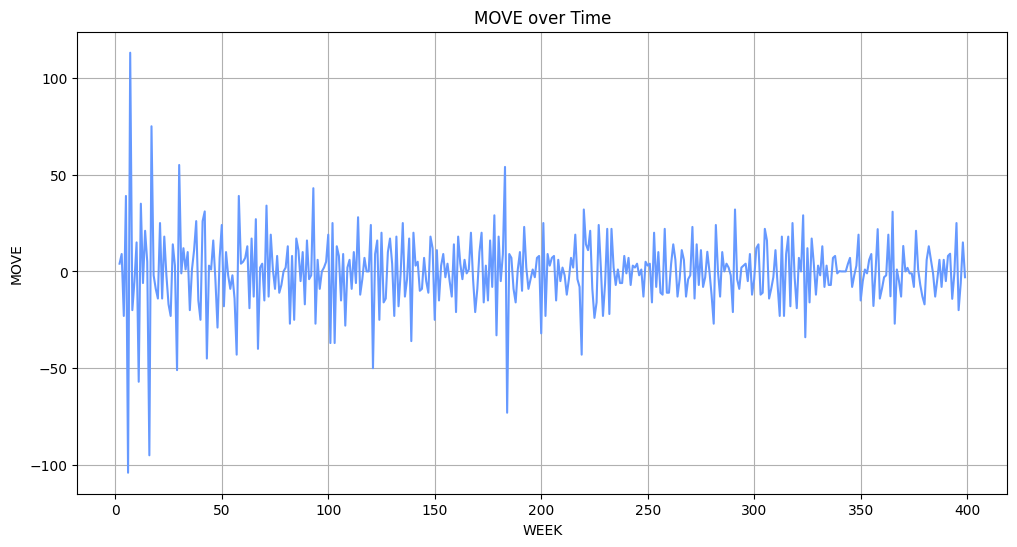

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(differenced_df, color = '#6699ff')
plt.title('MOVE over Time')
plt.xlabel('WEEK')
plt.ylabel('MOVE')
plt.grid(True)
plt.show()

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

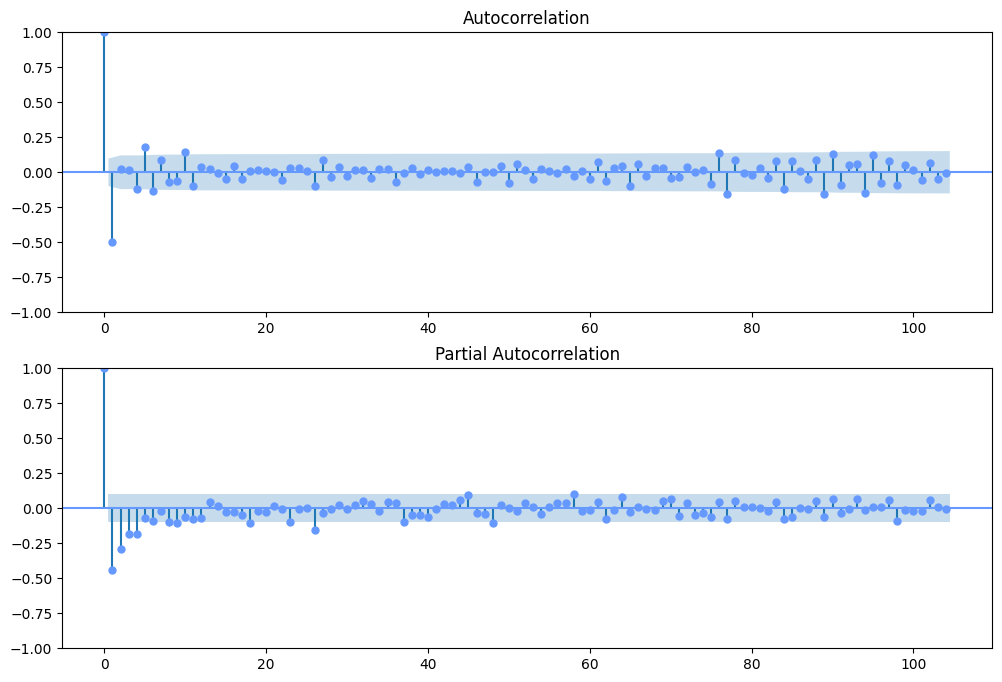

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(differenced_df['MOVE'].dropna(),lags=104, ax=ax1, color = '#6699ff')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_df['MOVE'].iloc[13:],lags=104, ax=ax2, color = '#6699ff')

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
model = ARIMA(selected_df['MOVE'][:320], order = (0,1,1))
model_fit = model.fit()

C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [29]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   MOVE   No. Observations:                  320
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1333.027
Date:                Mon, 06 Nov 2023   AIC                           2670.053
Time:                        00:52:46   BIC                           2677.584
Sample:                             0   HQIC                          2673.061
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8475      0.030    -28.394      0.000      -0.906      -0.789
sigma2       248.5602     10.661     23.316      0.000     227.666     269.454
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               335.79
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='WEEK'>

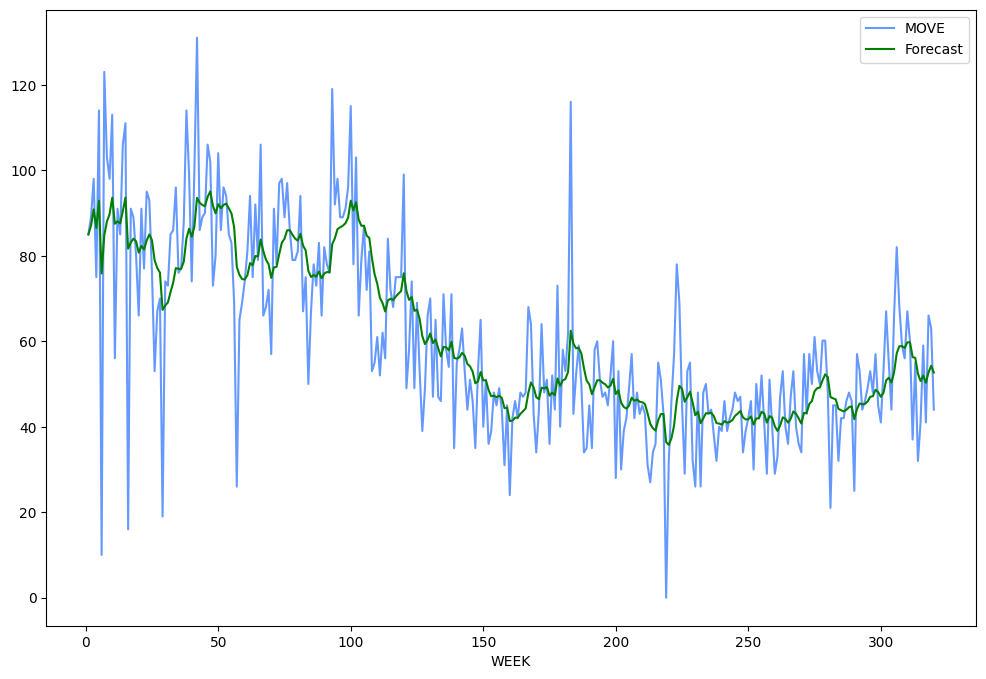

In [30]:
selected_df['Forecast'] = model_fit.predict(start=1, end=399, dynamic=False)
selected_df[['MOVE', 'Forecast']][:320].plot(figsize=(12, 8), color=['#6699ff','green'])


Text(0.5, 1.0, 'Arima Model')

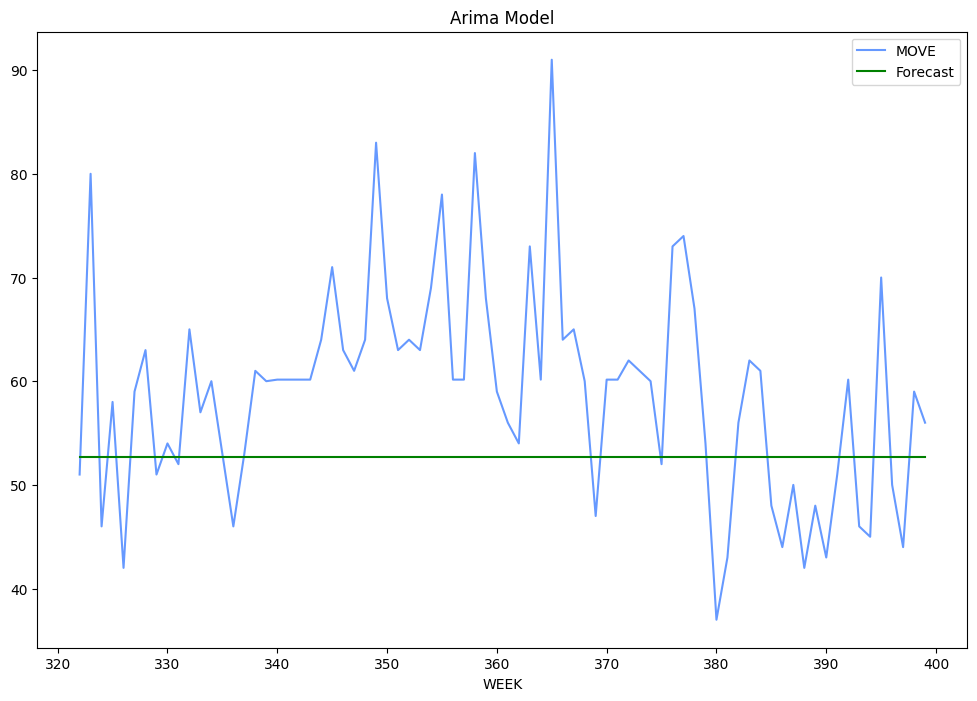

In [31]:
selected_df[['MOVE', 'Forecast']][321:].plot(figsize=(12, 8), color=['#6699ff','green'])
plt.title('Arima Model')

In [32]:
sarima_model = sm.tsa.SARIMAX(selected_df['MOVE'][:300], order=(0, 1, 1), seasonal_order=(1, 0, 0, 52))
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                MOVE   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1251.633
Date:                             Mon, 06 Nov 2023   AIC                           2509.266
Time:                                     00:52:47   BIC                           2520.367
Sample:                                          0   HQIC                          2513.709
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8562      0.031    -27.702      0.000      -0.917      -0.796
ar.S.L52       0.0675      

C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zisha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0.5, 1.0, 'Sarima Model')

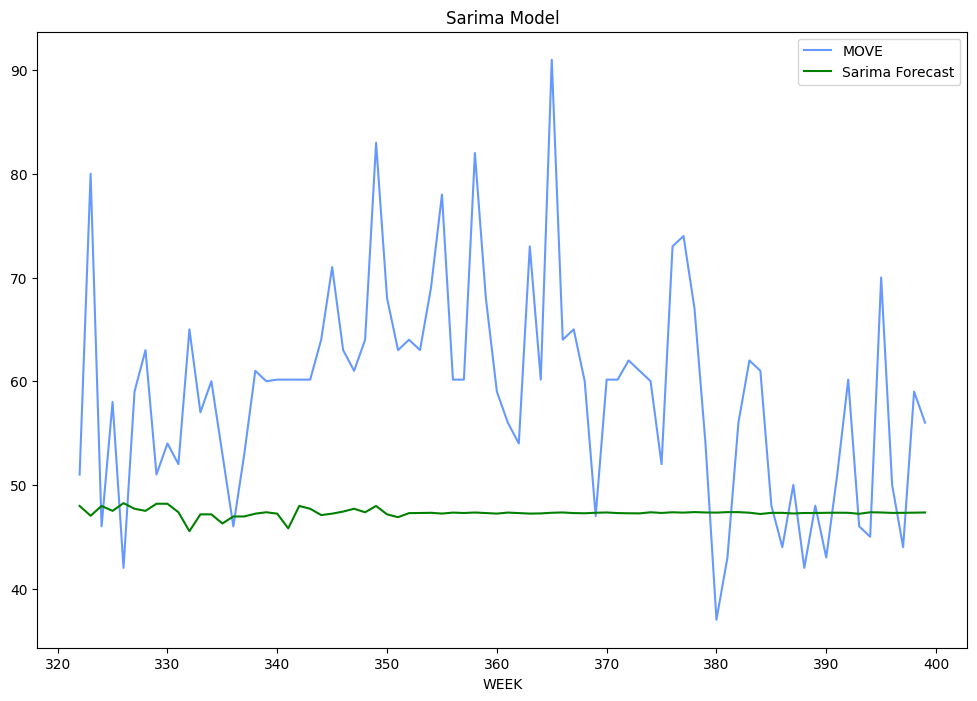

In [33]:
selected_df['Sarima Forecast'] = sarima_model_fit.predict(start=1, end=399, dynamic=False)
selected_df[['MOVE', 'Sarima Forecast']][321:].plot(figsize=(12, 8), color=['#6699ff','green'])
plt.title('Sarima Model')

In [34]:
# import pmdarima as pm
# from pmdarima.arima import auto_arima
# auto_arima_fit = auto_arima(selected_df['MOVE'][:320], seasonal=True, m=52, trace=True, error_action='ignore', suppress_warnings=True)

In [35]:
# selected_df['Auto Arima Forecast'] = auto_arima_fit.predict(n_periods=len(selected_df) - 320)
# selected_df[['MOVE', 'Auto Arima Forecast']].plot(figsize=(12, 8))

In [36]:
def calculate_errors(actual_values, predicted_values):
    mse = np.mean((actual_values - predicted_values) ** 2)
    mae = np.mean(np.abs(actual_values - predicted_values))
    rmse = np.sqrt(mse)

    return mse, mae, rmse

In [37]:
#Error for ARIMA Model
actual_values = selected_df['MOVE'][320:]
predicted_values = selected_df['Forecast'][320:]
mse, mae, rmse = calculate_errors(actual_values, predicted_values)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MSE: 142.54618292087417
MAE: 9.486195507388794
RMSE: 11.939270619299748


In [38]:
#Error for SARIMA Model
actual_values = selected_df['MOVE'][320:]
predicted_values = selected_df['Sarima Forecast'][320:]
mse, mae, rmse = calculate_errors(actual_values, predicted_values)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MSE: 239.117960824928
MAE: 12.692026770279037
RMSE: 15.463439488837146
